In [ ]:
## DeepExplain - Keras (TF backend) example
### MNIST with CNN

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

Using TensorFlow backend.


In [3]:
# Build and train a network.

batch_size = 128
num_classes = 10
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax')) 
# ^ IMPORTANT: notice that the final softmax must be in its own layer 
# if we want to target pre-softmax units

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 8s 127us/step - loss: 0.2459 - acc: 0.9234 - val_loss: 0.0513 - val_acc: 0.9837
Epoch 2/3
60000/60000 [==============================] - 7s 125us/step - loss: 0.0803 - acc: 0.9757 - val_loss: 0.0362 - val_acc: 0.9879
Epoch 3/3
60000/60000 [==============================] - 7s 125us/step - loss: 0.0593 - acc: 0.9827 - val_loss: 0.0318 - val_acc: 0.9886
Test loss: 0.031829339205852014
Test accuracy: 0.9886


In [4]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test[0:10]
    ys = y_test[0:10]
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    #attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    #attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    #attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    #attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    #attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)
    
    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=100)

CPU times: user 1min 40s, sys: 7.82 s, total: 1min 48s
Wall time: 1min 34s


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


CPU times: user 376 ms, sys: 148 ms, total: 524 ms
Wall time: 374 ms


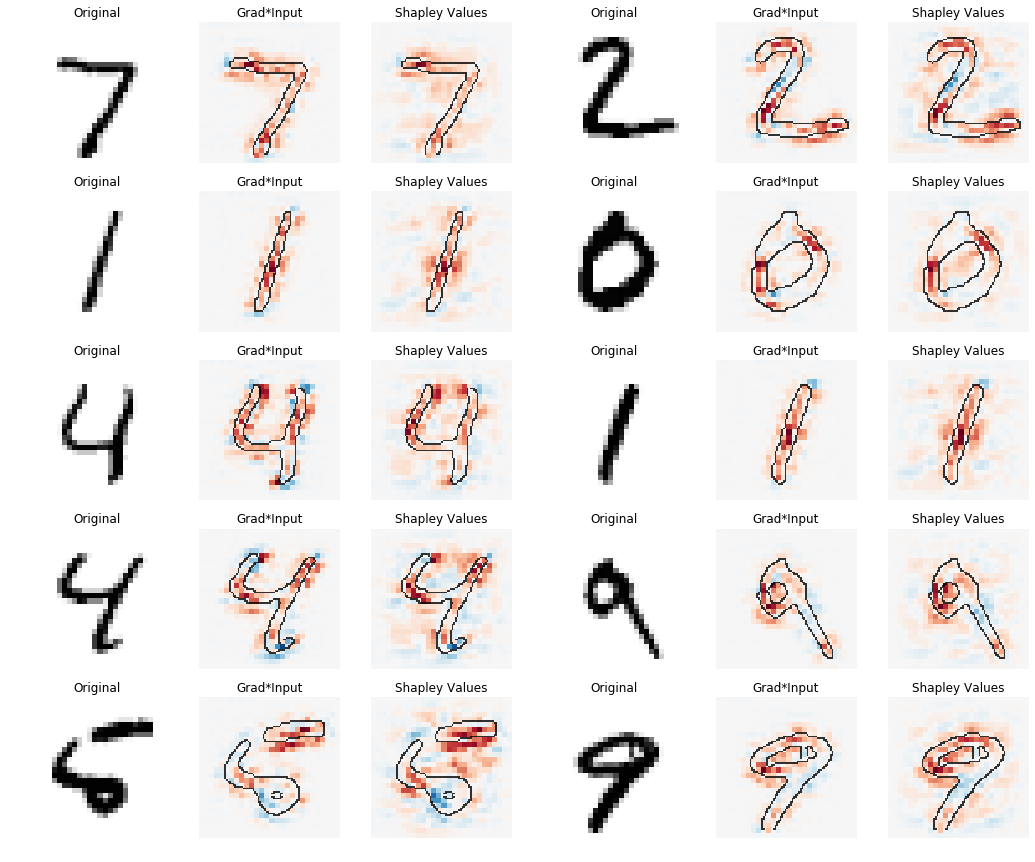

In [5]:
%%time
from utils import plot, plt
%matplotlib inline

n_cols = 6
n_rows = int(len(attributions_gradin) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, (a1, a2) in enumerate(zip(attributions_gradin, attributions_sv)):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
    plot(a1.reshape(28,28), xi = xs[i], axis=axes[row,col*3+1]).set_title('Grad*Input')
    plot(a2.reshape(28,28), xi = xs[i], axis=axes[row,col*3+2]).set_title('Shapley Values')

## Batch processing
In this example, we generate explanations for the entire testset (10000 images) using the fast Gradient*Input method.
`DeepExplain.explain()` accepts the `batch_size` parameter if the data to process does not fit in memory.

In [9]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test
    ys = y_test
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    print ("Done")

Done
CPU times: user 644 ms, sys: 124 ms, total: 768 ms
Wall time: 1.01 s
